# A neural network model of tone detection in 2AFC
To run this ipyb, please make sure you download and install neurogym https://github.com/ruyuanzhang/neurogym

However, you need to subsititute the task file with the task file in the OSF folder. 

The model file is tonenet_EI.py

The RNN network is CRNN_EI.py

In [1]:
#switch to neurogym path
import os, sys
path0=os.getcwd()
path1=path0+'\\neurogym-newtonedetection'
os.chdir(path1)
print(os.getcwd())

C:\Users\asus\CJY Folder\Projects\ToneDetection_Ruyuan Zhang\tonedetection2-main\neurogym-newtonedetection


In [2]:
import numpy as np
import torch
import gym
import torch.nn as nn
import neurogym as ngym
import matplotlib.pyplot as plt
from random import sample as rm_sample

# ========= define some parameters ===================

batch_size = 1000
dt = 25 # the time step is 25 ms

noise_length = 2000 # The noise piece length is 2 seconds, i.e., 2000 ms
decision = 0 # The decision is instant, so reaction time is not simulated here.

probability=0.2 # the probability that sti occur at the first period

distribution='normal'# choose exact distribution
## exact parameters: u, sigma, alpha,beta, etc,,



hidden_size = 100 # You can try different network sizes. We found that a network size less than 100 cannot do well at the noise level of 0.15 SD or above

output_size = 4  # A yes-no response. NO: no tone; Yes: a tone appears at one of the three locations.

# ========= initilize the neurogym task ============
task = 'NewToneDetection-v0' # be careful of the upper and lower case

# Remember to subsititute the task file in the toolbox with the task file in the OSF folder. 


# Make supervised dataset
delay = 500
fixation = [1000] # The fixation length here is just a value to initiate the task, so that you can check the stimuli. During the training, different fixation periods will be used in each batch.


timing = {'fixation': ('choice', (fixation)),
              'stimulus1':noise_length,
              'delay': delay,
              'stimulus2':noise_length, 
              'decision': decision}

seq_len = int((noise_length * 2 + fixation[0] + delay + decision)/dt) # The vector length of each trial


tone_mag = 1; # Tone magnitiude. We fixed the tone magnitude and changed SNR by increasing or decreasing noise levels.
sigma = 0.1; # External noise level, just a value to visualize the task and the network states


E:\Anaconda\lib\site-packages\gym\envs\registration.py:388: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


In [3]:
# Initialize the task using NeuroGym
# default
dataset = ngym.Dataset(task, env_kwargs={'dt': dt, 'sigma':sigma, 'tone_mag': np.log10(tone_mag),'timing':timing, 'p': probability, 'distribution':distribution}, batch_size=batch_size,
                       seq_len= seq_len, cache_len=0)
env = dataset.env


E:\Anaconda\lib\site-packages\gym\utils\env_checker.py:144: UserWarning: WARN: Agent's minimum observation space value is -infinity. This is probably too low.
  logger.warn(
E:\Anaconda\lib\site-packages\gym\utils\env_checker.py:148: UserWarning: WARN: Agent's maxmimum observation space value is infinity. This is probably too high
  logger.warn(
E:\Anaconda\lib\site-packages\gym\envs\registration.py:619: UserWarning: WARN: Env check failed with the following message: The environment cannot be reset with a random seed, even though `seed` or `kwargs` appear in the signature. This should never happen, please report this issue. The error was: reset() got an unexpected keyword argument 'seed'
You can set `disable_env_checker=True` to disable this check.
  logger.warn(


Here we initialize the task. The task file is included in neurogym neurogym/neurogym/env/tonedetection.py
We can use this structure to create training data and labels. See below example:

In [4]:
inputs, labels = dataset()
print("size of input is :", inputs.shape)
print("size of label is :", labels.shape)
#print(inputs)
#print(labels)
# Here the inputs are sequences. 

size of input is : (220, 1000, 1)
size of label is : (220, 1000)


The 1st dimension is the sequence length (2000 + 1000) ms / 25 ms time step = 120 points. 
The second is the batch_size for training the neural network.
The third dimension is the dimension of stimulus. Here we only have 1d auditory stimulus.
The dimensions of label are similar to inputs. But we only need the final output so we can drop the sequence dimension

Let's plot the stimulus, we want to plot four stimulus:no tone/1/2/3.

# Testing the ratio between sti1 and sti2

In [5]:
inputs, labels = dataset()

##test the ratio of first/second periods
stinum1=0
stinum2=0

# Gets the number of occurrences in both periods
for ii in np.arange(batch_size):
    #print(dataset.envs[ii].trial['condition'],'\t',dataset.envs[ii].trial['ground_truth'])
    #print(dataset.envs[ii].trial['stim1'],'\t',dataset.envs[ii].trial['stim2'])
    if dataset.envs[ii].trial['condition'] == 1:
        stinum1 += 1
    else:
        stinum2 += 1
print('Ratio of first/second:',stinum1/stinum2)
        

Ratio of first/second: 0.2547051442910916


[2 2 2 2 2 2 1 2 1 2]


Text(0.5, 1.0, 'tone at stim2')

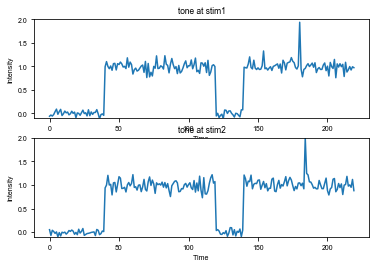

In [6]:
#plotting example
inputs, labels = dataset()
print(labels[-1,:10])
plt.close('all')
inputs = inputs.squeeze()
fig,ax = plt.subplots(2,1)
plt.sca(ax[0])
plt.plot(inputs[:,1]); plt.ylim([-0.1, 2]); plt.xlabel('Time '); plt.ylabel('Intensity');plt.title('tone at stim1')
plt.sca(ax[1])
plt.plot(inputs[:,9]); plt.ylim([-0.1, 2]); plt.xlabel('Time '); plt.ylabel('Intensity');plt.title('tone at stim2')


area under the curve: 1.0


E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


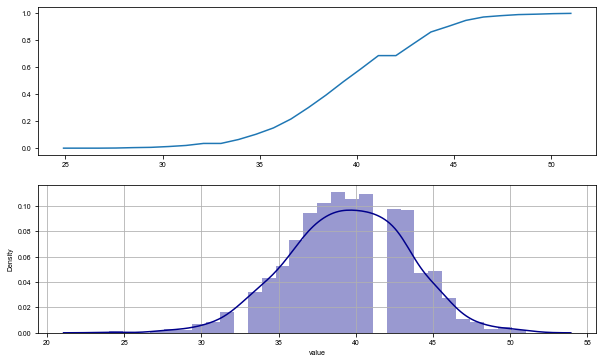

In [7]:
### specific on sample2(several batches' data)
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

inputs, labels = dataset()
tone_timing=[]

for i in range(batch_size):
    if labels[-1,i]==1:
        inputsti = inputs[:,i]
        timepoint= np.where(inputsti>1.5)[0]-(fixation[0])/dt## get the tone time points
    else:
        inputsti = inputs[:,i]
        timepoint= np.where(inputsti>1.5)[0]-(noise_length + fixation[0] + delay)/dt## get the tone time points
    #get the tone timepoints sequence
    tone_timing.append(timepoint[0]+1)

#ploting

# cumulative function
count, bins_count = np.histogram(tone_timing, bins=30)
pdf = count / sum(count)
cdf = np.cumsum(pdf)

fig = plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(2,1,1) 
ax1.plot(bins_count[1:], cdf, label="CDF")

# hist
ax2 = fig.add_subplot(2,1,2)
df = pd.DataFrame(tone_timing, columns =['value'])
ax = sns.distplot(df['value'], hist=True, kde=True, 
             bins=30, color = 'darkblue')
plt.grid()

#caculate hist's AUC 
values_sns = [h.get_height() for h in ax.patches]
bins_sns = [h.get_width() for h in ax.patches]

total_area = sum([height * width for height, width in zip(values_sns, bins_sns)])

print('area under the curve:',total_area) 

Mean and Std: 39.54 3.9073862961918464
It doesn't fit the normal distribution 
It doesn't fit the normal distribution 


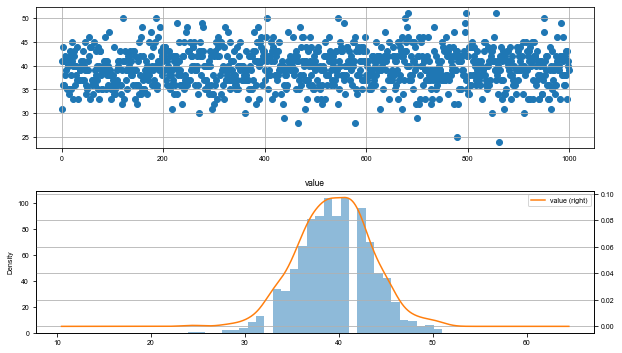

In [8]:
## distribution ploting

### specific on sample2(several batches' data)

from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
inputs, labels = dataset()
tone_timing=[]

for i in range(batch_size):
    if labels[-1,i]==1:
        inputsti = inputs[:,i]
        timepoint= np.where(inputsti>1.5)[0]-(fixation[0])/dt## get the tone time points
    else:
        inputsti = inputs[:,i]
        timepoint= np.where(inputsti>1.5)[0]-(noise_length + fixation[0] + delay)/dt## get the tone time points
    tone_timing.append(timepoint[0]+1)

df = pd.DataFrame(tone_timing, columns =['value'])
u = df['value'].mean() 
std = df['value'].std()
print('Mean and Std:',u,std)

## normal distribution test
ks_test=stats.kstest(tone_timing, 'norm')
if ks_test.pvalue>0.05:
    print("It fits the normal distribution ")
else: print("It doesn't fit the normal distribution ")


shapiro_test=stats.shapiro(tone_timing)
if ks_test.pvalue>0.05:
    print("It fits the normal distribution ")
else: print("It doesn't fit the normal distribution ")
    
## ploting scatter and hist
fig = plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(2,1,1) # 创建子图1
ax1.scatter(df.index, df.values)
plt.grid()
 
ax2 = fig.add_subplot(2,1,2) # 创建子图2
df.hist(bins=30,alpha = 0.5,ax = ax2)
df.plot(kind = 'kde', secondary_y=True,ax = ax2)
plt.grid()    

area under the curve: 0.9999999999999999


E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


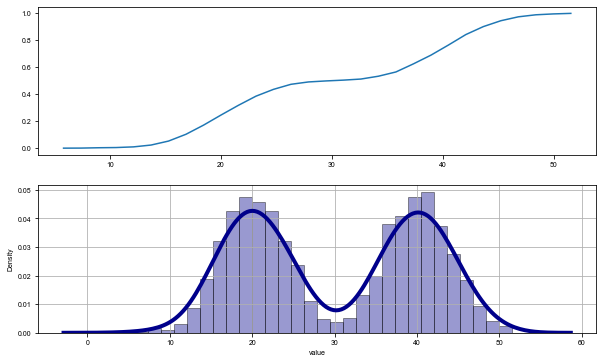

In [9]:
### specific on bi modal distribution of sample1(gaussian mixture)
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

nsize=1000
toneonset_u1,toneonset_u2 = 20,40
toneonset_sig1,toneonset_sig2 = 4,4

tonelen1 = 80
tonelen2 = 80

toneTimingIdx11 = np.random.normal(toneonset_u1,toneonset_sig1,nsize)
toneTimingIdx12 = np.random.normal(toneonset_u2, toneonset_sig2,nsize)
toneTimingIdx = np.concatenate([toneTimingIdx11, toneTimingIdx12])
## get the gaussian mixture

#ploting
count, bins_count = np.histogram(toneTimingIdx, bins=30)
pdf = count / sum(count)
cdf = np.cumsum(pdf)

fig = plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(2,1,1) 
ax1.plot(bins_count[1:], cdf, label="CDF")## cumulative bi modal distribution function

ax2 = fig.add_subplot(2,1,2)
df = pd.DataFrame(toneTimingIdx, columns =['value'])
ax = sns.distplot(df['value'], hist=True, kde=True, ## histogram 
             bins=30, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.grid()

values_sns = [h.get_height() for h in ax.patches]
bins_sns = [h.get_width() for h in ax.patches]

## caculate AUC
total_area = sum([height * width for height, width in zip(values_sns, bins_sns)])

print('area under the curve:',total_area)

# The following is not considered

In [8]:
# ============ do some check ================
device = 'cuda' if torch.cuda.is_available() else 'cpu'
inputs, labels = dataset()
inputs = torch.from_numpy(inputs).type(torch.float).to(device)
labels = torch.from_numpy(labels).type(torch.float).to(device)
input_size = inputs.shape[-1]
print('input_size is ', input_size)
device

input_size is  1


'cpu'

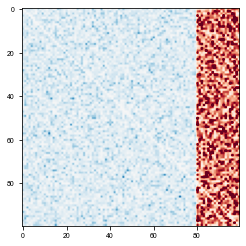

In [10]:
# Initialize RNN and plot weights
internal_sigma = 0.01 # set internal noise level to 0.01 SD, so we can vary external noise levels

from tonenet_EI import toneNet_EI # please see tonenet_EI.py for details. We only include RNN layer
net = toneNet_EI(input_size, hidden_size, output_size, dt = env.dt, sigma_rec=internal_sigma).to(device)
plt.imshow(net.rnn.h2h.effective_weight().detach().cpu().numpy(), vmin = -.5, vmax = .5, cmap='RdBu')


[1 1 0 1 3 0 0 2 0 2 2 3 2 0 1 3]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


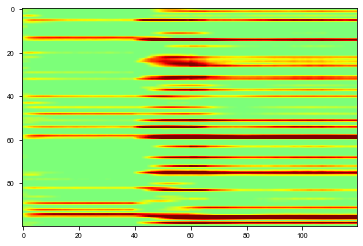

In [11]:
# plot initial hidden states

inputs, labels = dataset()

labels = labels[-1, :]
inputs = torch.from_numpy(inputs).type(torch.float).to(device) # need to convert numpy to tensor
modeloutput, allstates = net(inputs)
modeloutput = modeloutput.cpu().detach().numpy()
# find the choice
modeloutput = np.argmax(modeloutput, axis=1)
print(labels)
print(modeloutput)

plt.imshow(allstates[:,0,:].cpu().detach().numpy().T, vmin = -1, vmax = 1,  aspect='auto', cmap='jet')

In [18]:
20000%100

0



### **All the above are just for visualizing the task structure and the RNN structure. Next, we will train RNNs.**


In [12]:
### =============== train the network ===================
# we want to monitor loss and accuracy

lr = 1.e-3
lossfun = nn.CrossEntropyLoss()


external_sigma = [0.01,0.05,0.1,0.15,0.2]  # Five external noise levels

for temp_sigma in external_sigma[3:4]:
    print(temp_sigma)
    internal_sigma = 0.01

    # Initialize RNN
    net = toneNet_EI(input_size, hidden_size, output_size, dt = dt, sigma_rec=internal_sigma).to(device)

    # ADAM 
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15000, 30000], gamma=0.1) # for adaptive learning rate
    
    
    optimizer.zero_grad()


    lost_array = np.array([])
    accuracy_array = np.array([])
    running_loss = 0.0
    running_correct = 0 # running accurate trial

    for i in range(20000):#origianl 40000
      
        fixation = rm_sample(range(1000,1525,25),1) # The fixation period varies between 1000 ms to 1500 ms every batch

        timing = {'fixation': ('choice', (fixation)),
                  'stimulus':noise_length, 
                  'decision': decision}

        seq_len = int((noise_length + fixation[0] + decision)/dt) # 2000ms stimulus / 50ms window

        dataset = ngym.Dataset(task, env_kwargs={'dt': dt, 'sigma':temp_sigma, 'tone_mag': np.log10(tone_mag),'timing':timing}, batch_size=batch_size,
                          seq_len= seq_len, cache_len=0)

        #for ii in np.arange(batch_size):
        #    conditions[ii] = dataset.envs[ii].trial['condition']

        #for 

        inputs, labels = dataset()




        labels = labels[-1, :] # we only need the final output
        inputs = torch.from_numpy(inputs).type(torch.float).to(device) # need to convert numpy to tensor
        labels = torch.from_numpy(labels).to(device) # need to convert numpy to tensor

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward calculation
        outputs, _ = net(inputs)
        
        # calculate loss and backward the gradient
        loss = lossfun(outputs.view(-1, output_size), labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # print statistics
        running_loss += loss.item()
        # calculate accuracy
        correct = np.argmax(outputs.cpu().detach().numpy(), axis=1)
        correct = (correct == labels.cpu().numpy()).sum()
        running_correct += correct
        
        # we output the loss and acc during the training. The loss should reach very low

        # If the performance did not increase above 99%, we stop the training at 40000 steps
        if i > 19998:#original 39998
            model_file_name = 'tonedectione_ENoise%s_Inoise_%s.pt' % (temp_sigma, internal_sigma)    
            torch.save(net.state_dict(),model_file_name)

            lost_array_file_name = 'lost_array_ENoise%s_Inoise_%s.npy' % (temp_sigma, internal_sigma) 
            with open(lost_array_file_name, 'wb') as f:
              np.save(f, lost_array)
            
            accuracy_array_file_name = 'accuracy_array_ENoise%s_Inoise_%s.npy' % (temp_sigma, internal_sigma) 
            with open(accuracy_array_file_name, 'wb') as f:
              np.save(f, lost_array)
              
        # If the performance averaged over 100 batches is above 99%, we stop the training
        if i % 100 == 99:
            lost_array = np.append(lost_array,running_loss / 100 / batch_size * 1000)
            accuracy_array = running_correct/100/batch_size
            print(f'{i+1} loss: {running_loss / 100 / batch_size * 1000:.5f}, acc: {running_correct/100/batch_size}')
            if running_correct/100/batch_size > 0.99:

              model_file_name = 'tonedectione_ENoise%s_Inoise_%s.pt' % (temp_sigma, internal_sigma)    
              torch.save(net.state_dict(),model_file_name)

              lost_array_file_name = 'lost_array_ENoise%s_Inoise_%s.npy' % (temp_sigma, internal_sigma) 
              with open(lost_array_file_name, 'wb') as f:
                np.save(f, lost_array)

              accuracy_array_file_name = 'accuracy_array_ENoise%s_Inoise_%s.npy' % (temp_sigma, internal_sigma) 
              with open(accuracy_array_file_name, 'wb') as f:
                np.save(f, lost_array)
              break
            

            running_loss = 0.0
            running_correct = 0


print('Finished Training')

0.15


E:\Anaconda\lib\site-packages\gym\utils\env_checker.py:144: UserWarning: WARN: Agent's minimum observation space value is -infinity. This is probably too low.
  logger.warn(
E:\Anaconda\lib\site-packages\gym\utils\env_checker.py:148: UserWarning: WARN: Agent's maxmimum observation space value is infinity. This is probably too high
  logger.warn(
E:\Anaconda\lib\site-packages\gym\envs\registration.py:619: UserWarning: WARN: Env check failed with the following message: The environment cannot be reset with a random seed, even though `seed` or `kwargs` appear in the signature. This should never happen, please report this issue. The error was: reset() got an unexpected keyword argument 'seed'
You can set `disable_env_checker=True` to disable this check.
  logger.warn(


100 loss: 87.08583, acc: 0.256875
200 loss: 86.68265, acc: 0.26625
300 loss: 86.70899, acc: 0.2475
400 loss: 86.62794, acc: 0.248125
500 loss: 86.14503, acc: 0.283125
600 loss: 81.66641, acc: 0.390625
700 loss: 71.08285, acc: 0.464375
800 loss: 59.51145, acc: 0.5925
900 loss: 50.02988, acc: 0.62875
1000 loss: 42.81917, acc: 0.690625
1100 loss: 44.75709, acc: 0.65625
1200 loss: 40.82320, acc: 0.691875
1300 loss: 39.49709, acc: 0.695
1400 loss: 37.05217, acc: 0.7
1500 loss: 37.42500, acc: 0.696875
1600 loss: 37.72465, acc: 0.696875
1700 loss: 38.16327, acc: 0.6825
1800 loss: 37.38832, acc: 0.690625
1900 loss: 33.49734, acc: 0.7125
2000 loss: 35.98030, acc: 0.70125
2100 loss: 34.20994, acc: 0.718125
2200 loss: 36.49144, acc: 0.6975
2300 loss: 32.68931, acc: 0.713125
2400 loss: 34.65694, acc: 0.7075
2500 loss: 36.17033, acc: 0.693125
2600 loss: 28.00684, acc: 0.75
2700 loss: 32.88001, acc: 0.71625
2800 loss: 30.82719, acc: 0.710625
2900 loss: 29.68871, acc: 0.743125
3000 loss: 33.30111, ac

## **After we finish training, we load a trained RNN to visualize it**

In [ ]:
external_sigma = 0.15
internal_sigma = 0.01

model_file_name = 'tonedectione_ENoise%s_Inoise_%s.pt' % (external_sigma, internal_sigma)    
net = toneNet_EI(input_size, hidden_size, output_size, dt = dt, sigma_rec=internal_sigma).to(device)
net.load_state_dict(torch.load(model_file_name))
net.eval()           


We finish training. Now check the performance of the neural network 

In [ ]:
sigma = 0.15;

fixation[0] = 1000
decision = 0

timing = {'fixation': ('choice', (fixation)),
            'stimulus':noise_length, 
            'decision': decision}

seq_len = int((noise_length + fixation[0] + decision)/dt) # 2000ms stimulus / 50ms window


dataset = ngym.Dataset(task, env_kwargs={'dt': dt, 'sigma':sigma, 'tone_mag': np.log10(tone_mag),'timing':timing}, batch_size=batch_size,
                       seq_len= seq_len, cache_len=0)

In [ ]:
inputs, labels = dataset()
labels = labels[-1, :]
inputs = torch.from_numpy(inputs).type(torch.float).to(device) # need to convert numpy to tensor
modeloutput, allstates = net(inputs)
modeloutput = modeloutput.cpu().detach().numpy()
# find the choice
modeloutput = np.argmax(modeloutput, axis=1)
print(labels)
print(modeloutput)

[1 1 1 1 0 1 1 0 0 1 0 0 1 1 1 0]
[1 1 1 1 0 1 1 0 0 1 0 0 1 1 1 0]


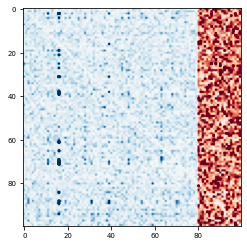

In [ ]:
plt.imshow(net.rnn.h2h.effective_weight().cpu().detach().numpy(),  vmin = -0.5, vmax = 0.5, cmap='RdBu')

In [ ]:
allstates.shape

torch.Size([120, 16, 100])

In [ ]:
for ii in np.arange(batch_size):
           print(dataset.envs[ii].trial['condition'])

1
2
1
3
3
2
3
1
0
2
2
3
1
0
3
0


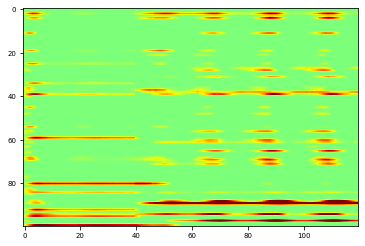

In [ ]:
plt.imshow(allstates[:,15,:].cpu().detach().numpy().T, vmin = -1, vmax = 1,  aspect='auto', cmap='jet')